In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import warnings
import matplotlib.pyplot as plt
import os

Matplotlib is building the font cache; this may take a moment.


In [3]:
import gfdl_utils.core as gu

In [4]:
models = {
    "CM4p25"  : {"historical":"odiv-231", "ssp5":"odiv-232"},
    "CM4p125" : {"historical":"odiv-255", "ssp5":"odiv-293"}
}

pre = "/archive/Raphael.Dussin/"
pp_dict = {
    "odiv-230": f"{pre}FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp",
    "odiv-231": f"{pre}FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp",
    "odiv-232": f"{pre}FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp",
    "odiv-209": f"{pre}FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp",
    "odiv-255": f"{pre}FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp",
    "odiv-293": f"{pre}FMS2019.01.03_devgfdl_20230608/CM4_ssp585_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp"
}

pre = "/archive/Raphael.Dussin/datasets/"
sg_dict = {
    "OM4p25": f"{pre}OM4p25/c192_OM4_025_grid_No_mg_drag_v20160808_unpacked/ocean_hgrid.nc",
    "OM4p125": f"{pre}OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc"
}

def get_pathDict(run, time="*", snap=False):
    pp = pp_dict[run]
    return {
        "pp": pp,
        "ppname": f"ocean_inert_month",
        "out": "ts",
        "local": "monthly/5yr",
        "time": time,
        "add": "*"
    }

In [ ]:
tracers = ['cfc11', 'cfc12', 'sf6']
g_per_mol = {
    "cfc11": 137.37,
    "cfc12": 120.91,
    "sf6": 146.06
}
Gg_per_g = 1.e-9
sec_per_year = 365.25 * 24 * 60 * 60
sec_per_nsec = 1.e-9

In [18]:
data_dict = {}

for model, exps in models.items():
    print(f"Loading inert tracer diagnostics for {model}")
    hist = gu.open_frompp(**get_pathDict(exps["historical"]), chunks={'time':1})
    ssp5 = gu.open_frompp(**get_pathDict(exps["ssp5"]), chunks={'time':1})
    ds = xr.concat([hist, ssp5], dim="time", combine_attrs="override")

    path_dict = get_pathDict(exps["historical"])
    og = xr.open_dataset(gu.get_pathstatic(path_dict["pp"], path_dict["ppname"]))
    
    inv_path = f"../data/transient_tracer_inventory_{model}-SSP585.nc"
    if not(os.path.exists(inv_path)):
        print(f"Computing globally-integrated inventory for {model}: ")
        inv = xr.Dataset()
        for tr in tracers:
            print(tr, end=", ")
            inv[f'{tr}_volumeint'] = (ds[tr]*ds['volcello']).sum(['xh', 'yh', 'zl']).compute()
            inv[f'fg{tr}_areaint'] = (ds[f'fg{tr}']*og['areacello']).sum(['xh', 'yh']).compute()
            Δt = ds['average_DT'].astype("float64")*sec_per_nsec
            inv[f'fg{tr}_areatimeint'] = (inv[f'fg{tr}_areaint']*Δt).cumsum("time").compute()
        print("")
        inv.to_netcdf(inv_path)
    else:
        print(f"Loading globally-integrated inventory for {model}.")
        inv = xr.open_dataset(inv_path)
        
    data_dict[model] = {"ds":ds, "og":og, "inv":inv}

Loading inert tracer diagnostics for CM4p25
Loading globally-integrated inventory for CM4p25.
Loading inert tracer diagnostics for CM4p125
Loading globally-integrated inventory for CM4p125.


In [19]:
import cftime
import numpy as np
import matplotlib.dates as mdates

In [20]:
bc = xr.open_dataset("/archive/hfd/datasets/input_files/CFC_SSP585_20x20deg.20220203.nc", decode_times=False)
bc = bc.assign_coords({'Year': bc['Time'].copy() + 1601})
bc['Year'].attrs = {}
bc['Time'] = bc['Time']*365.242198781
bc['Time'].attrs['units'] = 'days since 1601-01-01 00:00:00'
bc = xr.decode_cf(bc, use_cftime=True)

In [21]:
glo = xr.open_dataset("../data/glodap_v1/glodap_cfc.nc")

R = 6378.1e3
glo['dz'] = xr.ones_like(glo['depth'])
glo['dz'].data = np.diff(glo['depth_bnds'])
glo['dA'] = R**2 * np.abs(np.sin(np.deg2rad(glo['lat']+0.5)) - np.sin(np.deg2rad(glo['lat']-0.5))) * np.deg2rad((glo['lon']+0.5) - (glo['lon']-0.5))
glo['volcello'] = glo.dz * glo.dA

rho0 = 1035.
glo['CFC11_inv'] = (glo.CFC11*1e-12*rho0 * glo.volcello).sum()
glo['CFC12_inv'] = (glo.CFC12*1e-12*rho0 * glo.volcello).sum()

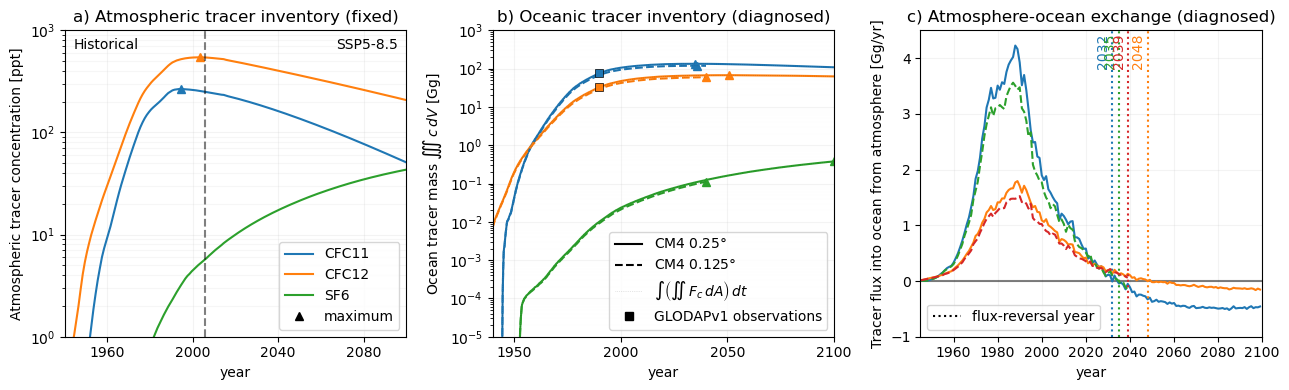

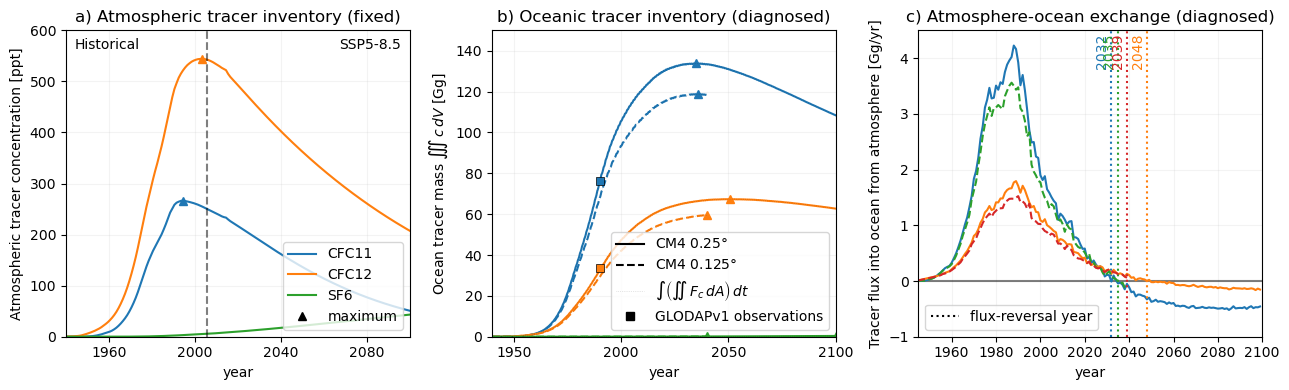

In [22]:
cols = {'cfc11':'C0', 'cfc12':'C1', 'sf6':'C2'}
labels = {'cfc11':'CFC11', 'cfc12':'CFC12', 'sf6':'SF6'}
long_exps = {'historical': 'Historical', 'ssp585':'SSP5-8.5'}

for yscale, ylim1, ylim2 in zip(
        ["log", "linear"],
        [[1., 1e3], [0., 600]],
        [[1e-5, 1e3], [0., 150]]
    ):
    fig = plt.figure(figsize=(13, 4))

    ax = plt.subplot(1,3,1)

    for label in labels.values():
        line = bc[label].mean(['Longitude', 'Latitude']).plot(label=label)
        timax = bc[label].mean(['Longitude', 'Latitude']).argmax()
        plt.plot(
            bc[label].mean(['Longitude', 'Latitude']).isel(Time=[timax])['Time'],
            bc[label].mean(['Longitude', 'Latitude']).isel(Time=[timax]),
            '^', linewidth=0., color=line[0].get_c()
        )
    plt.plot([], [], "k^", label="maximum")
    plt.axvline(2014, linestyle="--", color="k", alpha=0.5, linewidth=1.5)
    plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
    plt.grid(True, alpha=0.15, which="major", lw=0.75)
    plt.grid(True, alpha=0.1, which="minor")
    plt.ylabel("Atmospheric tracer concentration [ppt]")
    plt.annotate(long_exps['historical'], xy=(0.025, 0.975), xycoords="axes fraction", ha="left", va="top")
    plt.annotate(long_exps['ssp585'], xy=(0.975, 0.975), xycoords="axes fraction", ha="right", va="top")
    plt.legend(loc="lower right")
    plt.ylim(ylim1)
    plt.yscale(yscale)
    plt.xlabel("year")
    plt.title("a) Atmospheric tracer inventory (fixed)", fontsize=12)

    ax = plt.subplot(1,3,2)
    for (model, dd), ls in zip(data_dict.items(), ["-", "--"]):
        inv = dd['inv']
        for tr in tracers:
            line = plt.plot(inv['time'], inv[f'{tr}_volumeint'] * g_per_mol[tr] * Gg_per_g, color=cols[tr], ls=ls)
            timax = inv[f'{tr}_volumeint'].argmax()
            plt.plot(
                inv[f'{tr}_volumeint'].isel(time=[timax])['time'],
                inv[f'{tr}_volumeint'].isel(time=[timax]) * g_per_mol[tr] * Gg_per_g,
                '^', linewidth=0., color=line[0].get_c()
            )
            (inv[f'fg{tr}_areatimeint'] * g_per_mol[tr] * Gg_per_g).plot(color="k", ls=":", alpha=0.2, lw=0.5)

    for tr, color in zip(['cfc11', 'cfc12'], ["C0", "C1"]):
        plt.plot(
            cftime.datetime(1990, 1, 1),
            glo[f'{labels[tr]}_inv'] * g_per_mol[tr] * Gg_per_g,
            marker="s", color=color, markeredgecolor="k", markeredgewidth=0.5
        )
    plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
    plt.grid(True, alpha=0.15, which="major", lw=0.75)
    plt.grid(True, alpha=0.1, which="minor", lw=0.05)
    plt.ylabel("Ocean tracer mass $\iiint\, c \, dV$ [Gg]")
    plt.plot([], [], ls="-", color="k", label=r"CM4 0.25$\degree$")
    plt.plot([], [], ls="--", color="k", label=r"CM4 0.125$\degree$")
    plt.plot([], [], ls=":", color="k", alpha=0.2, lw=0.5, label=r"$\int \left( \iint\,F_{c} \, dA \right) \, dt$")
    plt.plot([], [], "ks", label=r"GLODAPv1 observations")
    plt.legend()
    plt.xlabel("year")
    plt.ylim(ylim2)
    plt.yscale(yscale)
    plt.title("b) Oceanic tracer inventory (diagnosed)", fontsize=12)
    
    plt.subplot(1,3,3)
    plt.axhline(0., color="k", lw=1.5, alpha=0.5)
    for (model, dd), ls in zip(data_dict.items(), ["-", "--"]):
        inv = dd['inv']
        for tr in tracers:
            if "sf6" in tr: continue
            tr_flux = inv[f'fg{tr}_areaint'].groupby("time.year").mean("time") * g_per_mol[tr] * sec_per_year * Gg_per_g
            line = tr_flux.plot(ls=ls)
            reversal_year = tr_flux['year'].isel(year=np.abs(tr_flux).where(tr_flux['year'] > 2000).argmin())
            plt.axvline(reversal_year, color=line[0].get_color(), ls=":")
            plt.annotate(str(reversal_year.values), (reversal_year-1., 4.45), rotation="90", ha="right", va="top", color=line[0].get_color())

    plt.plot([], [], ls=":", color="k", label="flux-reversal year")
    plt.legend()
    plt.xlim([1945, 2100])
    plt.ylim(-1, 4.5)
    plt.grid(True, alpha=0.15, which="major", lw=0.75)
    plt.grid(True, alpha=0.1, which="minor", lw=0.05)
    plt.ylabel("Tracer flux into ocean from atmosphere [Gg/yr]")
    plt.title("c) Atmosphere-ocean exchange (diagnosed)", fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f"../figures/transient_tracer_boundary_conditions_and_inventories_{yscale}.png", dpi=200., bbox_inches="tight")

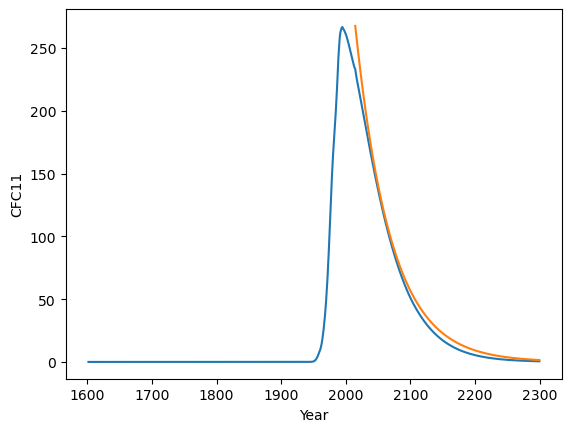

In [219]:
bc["CFC11"].mean(['Longitude', 'Latitude']).plot(x="Year")
x = bc.Year
τ = 55.
y = 270 * np.exp(- (bc.Year - 2014)/τ).where(bc.Year >= 2014)
plt.plot(x, y)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

t = -5
ρ0 = 1035. # kg/m^3

cmap = plt.get_cmap("plasma").copy()
cmap.set_bad((0.25, 0.25, 0.25))
fig, axes = plt.subplots(3,1, figsize=(12, 10))
for i, tr in enumerate(['cfc11', 'cfc12', 'sf6'], start=0):
    pc = (ds_z[tr]/ρ0*1e12).roll(xh=485).sel(yh=-32.5, method="nearest").isel(time=t).plot(
        ax=axes[i],
        cmap=cmap, levels=21,
        vmin=0, vmax=0.2,
    )
    pc.colorbar.set_label("Concentration [pmol/kg]")
    axes[i].set_ylim(6000, 3000)
    axes[i].set_title(f"{ds[tr].long_name} at time {ds.time.isel(time=t).values}")
fig.tight_layout()